In [2]:
from pathlib import Path
from modules.decomposeSTN import decomposeSTN as STN

import config
import librosa
import json

import numpy as np
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

In [3]:
def plot_fuzzy_energy(input: np.array, outputs: np.ndarray, outputs_names: list[str], sr: int, output_plot_path: str = None):
    def get_fuzzy_energy(x: np.array, sr: int):
        X = librosa.stft(x)
        Xn = np.abs(X)
        Y = np.sum(Xn**2, axis=0)
        Y_db = librosa.power_to_db(Y, ref=np.max)
        return Y_db

    nWin1 = 8192 # samples
    nWin2 = 512 # samples

    [xs, xt, xn] = STN.decSTN(input, sr, nWin1, nWin2)

    Xs = get_fuzzy_energy(xs, sr)
    Xt = get_fuzzy_energy(xt, sr)
    Xn = get_fuzzy_energy(xn, sr)

    fuzzy_energy = {
        "sines":[],
        "transients":[],
        "noise":[],
        "name": []
    }

    for output, name in zip(outputs, outputs_names):
        [ys, yt, yn] = STN.decSTN(output, sr, nWin1, nWin2)
        fuzzy_energy["sines"].append(get_fuzzy_energy(ys, sr))
        fuzzy_energy["transients"].append(get_fuzzy_energy(yt, sr))
        fuzzy_energy["noise"].append(get_fuzzy_energy(yn, sr))
        fuzzy_energy["name"].append(name)

    len_fuzzy_energy = len(fuzzy_energy["sines"][0])
    # interpolate Xs, Xt, Xn to match the length of the outputs
    zoom_factor = len_fuzzy_energy / len(Xs)
    Xs = zoom(Xs, zoom_factor)
    Xt = zoom(Xt, zoom_factor)
    Xn = zoom(Xn, zoom_factor)

    fuzzy_energy["sines"].append(Xs)
    fuzzy_energy["transients"].append(Xt)
    fuzzy_energy["noise"].append(Xn)
    fuzzy_energy["name"].append("Original")

    df = pd.DataFrame(fuzzy_energy)

    time = np.linspace(0, len(input) / sr, len(df['sines'][0]))

    plt.figure(figsize=(10, 10))
    plt.subplot(3, 1, 1)
    for signal, name in zip(df['sines'], df['name']):
        plt.plot(time, signal, label=name)
    plt.title('Sines')
    plt.ylabel('Energy (dB)')
    plt.legend()

    plt.subplot(3, 1, 2)
    for signal, name in zip(df['transients'], df['name']):
        plt.plot(time, signal, label=name)
    plt.title('Transients')
    plt.ylabel('Energy (dB)')
    plt.legend()

    plt.subplot(3, 1, 3)
    for signal, name in zip(df['noise'], df['name']):
        plt.plot(time, signal, label=name)
    plt.title('Noise')
    plt.ylabel('Energy (dB)')
    plt.legend()

    plt.xlabel('Time (s)')
    plt.tight_layout()

    if output_plot_path is None:
        plt.show()
    else:
        plt.savefig(output_plot_path)
        plt.close()
    


In [ ]:
def spectral_envelopes_mse(input: np.array, outputs: np.ndarray, outputs_names: list[str], sr: int, output_plot_path: str = None):
    # nice and all but if we just feed a not working algorithm that doesn't change the output at all, the mse will be 0
    def calculate_spectral_envelope(signal: np.array, sr: int):
        S = np.abs(librosa.stft(signal))
        envelope = np.max(S, axis=0)
        return envelope

    original_envelope = calculate_spectral_envelope(input, sr)

    mse_values = {
        "name": [],
        "mse": []
    }

    plt.figure(figsize=(10, 5))
    freqs = np.linspace(0, sr / 2, len(original_envelope))
    plt.plot(freqs, original_envelope, color="r", label="Original Spectral Envelope")

    for output, name in zip(outputs, outputs_names):
        output_envelope = calculate_spectral_envelope(output, sr)
        mse = np.mean((output_envelope - original_envelope)**2)
        mse_values["name"].append(name)
        mse_values["mse"].append(mse)
        plt.plot(freqs, output_envelope, label=f"Spectral Envelope - {name}")

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.title("Spectral Envelopes")
    plt.legend()

    if output_plot_path is None:
        plt.show()
    else:
        plt.savefig(output_plot_path)
        plt.close()

    # for name, mse in zip(mse_values["name"], mse_values["mse"]):
    #     print(f"Mean Squared Error for {name}: {mse}")

In [ ]:
# Metric for pitch shifting:
def decay_rate_deviation(input: np.array, outputs: np.ndarray, outputs_names: list[str], sr: int, output_plot_path: str = None):
    def calculate_decay_rate(y:np.array,hop_length: int):
        rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
        # define decay rate as the rate of change of the RMS envelope
        decay_rate = np.abs(np.diff(rms, prepend=[0]))
        return decay_rate
    # Compute RMS envelope for input
    frame_length = 500
    hop_length = frame_length // 2
    x_rms = calculate_decay_rate(input, hop_length)
    times = librosa.frames_to_time(np.arange(len(x_rms)), sr=sr, hop_length=hop_length)
    
    decay_rates = {
        "name": [],
        "decay_rate_deviation": []
    }

    plt.figure(figsize=(10, 5))
    plt.plot(times, x_rms, color="r", label="Decay Rate Input")

    for output, name in zip(outputs, outputs_names):
        y_rms = calculate_decay_rate(output, hop_length)
        R_dr_L1 = np.mean((y_rms / x_rms) - 1)
        decay_rates["name"].append(name)
        decay_rates["decay_rate_deviation"].append(R_dr_L1)
        plt.plot(times, y_rms, label=f"Decay Rate - {name}")

    # Plot original audio in the background
    # plt.plot(np.linspace(0, len(input) / sr, len(input)), input, color="gray", alpha=0.5, label="Original Audio")

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("RMS Envelope of the Signal")
    plt.legend()

    if output_plot_path is None:
        plt.show()
    else:
        plt.savefig(output_plot_path)
        plt.close()

    # for name, rate in zip(decay_rates["name"], decay_rates["decay_rate_deviation"]):
    #     print(f"Decay Rate Deviation for {name}: {rate}")




In [6]:
def run_audio_metrics(files: list[str] =  ["p225/p225_020.wav", "p226/p226_020.wav", "p227/p227_020.wav"], factors_ps = config.NO_REFERENCE_FACTORS["ps_factors"], factors_tsm = config.REFERENCE_FACTORS["tsm_factors"]):
    Path(f"{config.EVAL_OBJ_DIR}/tsmps/").mkdir(parents=True, exist_ok=True)
    for file in files:
        file_stem = Path(file).stem
        input_path = Path(f"{config.INPUT_DIR}/wav48/{file}")
        x, sr = librosa.load(input_path, sr=None)
        
        for factor in factors_tsm:
            ys_tsm = []
            tsm_algorithms = []
            for tsm_algorithm in config.TSM_ALGORITHMS:
                output_path = Path(f"{config.OUTPUT_DIR}/wav48/tsm/{tsm_algorithm.name}/{factor}/{file}")
                y_tmp, sr = librosa.load(output_path, sr=None)
                ys_tsm.append(y_tmp)
                tsm_algorithms.append(tsm_algorithm.name)
            
            # Run the metrics
            decay_rate_deviation(x, ys_tsm, tsm_algorithms, sr)
            spectral_envelopes_mse(x, ys_tsm, tsm_algorithms, sr)
            plot_fuzzy_energy(x, ys_tsm, tsm_algorithms, sr)

        
        for factor in factors_ps:
            ys_ps = []
            ps_algorithms = []
            for ps_algorithm in config.PS_ALGORITHMS:
                output_path = Path(f"{config.OUTPUT_DIR}/wav48/ps/{ps_algorithm.name}/{factor}/{file}")
                y_tmp, sr = librosa.load(output_path, sr=None)
                ys_ps.append(y_tmp)
                ps_algorithms.append(ps_algorithm.name)
                
            # Run the metrics
            decay_rate_deviation(x, ys_ps, ps_algorithms, sr)
            spectral_envelopes_mse(x, ys_ps, ps_algorithms, sr)
            plot_fuzzy_energy(x, ys_ps, ps_algorithms, sr)
            


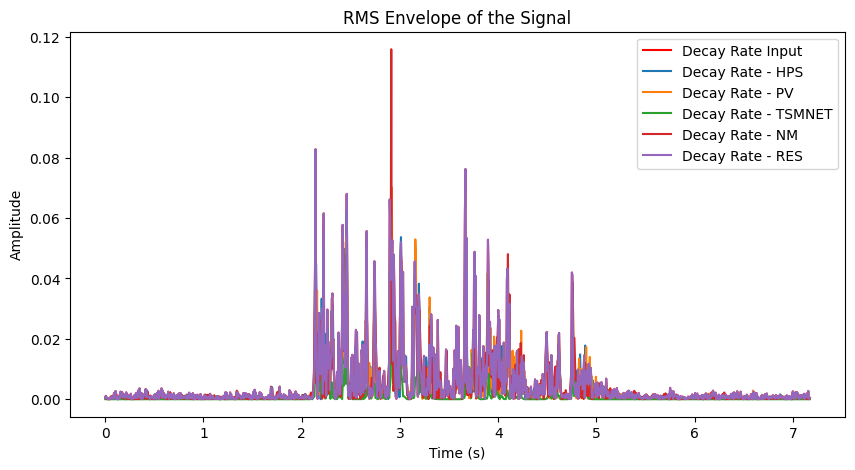

Decay Rate Deviation for HPS: 1.4627385182403336
Decay Rate Deviation for PV: 2.008568140847819
Decay Rate Deviation for TSMNET: -0.7691362982300546
Decay Rate Deviation for NM: 2.4803705588475973
Decay Rate Deviation for RES: 0.007215446707538236


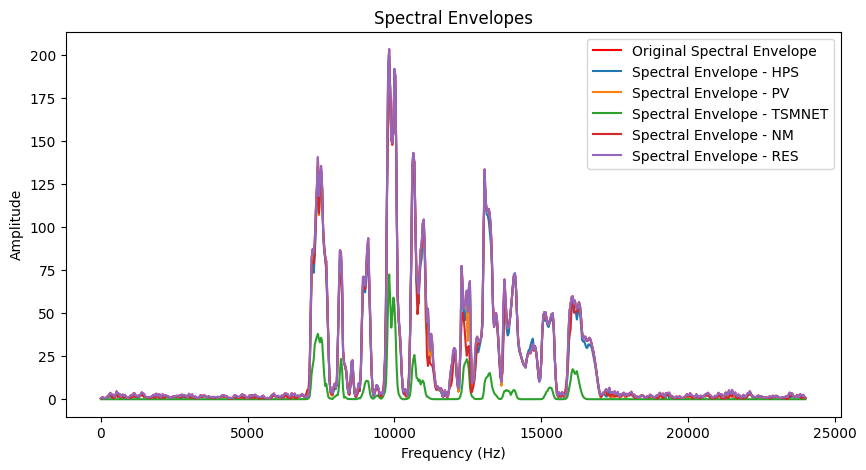

Mean Squared Error for HPS: 8.412083625793457
Mean Squared Error for PV: 4.71036434173584
Mean Squared Error for TSMNET: 1004.1686401367188
Mean Squared Error for NM: 23.830018997192383
Mean Squared Error for RES: 6.538338493555784e-05


In [ ]:
run_audio_metrics(files=['p225/p225_020.wav'], factors_ps=[12], factors_tsm=["rt_up"])